In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
import os
from glob import glob
import matplotlib.colors
import itertools
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from shapely.geometry import box
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
from sklearn.metrics import silhouette_score
from spopt.region import SA3

import preprocess_data

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

<Axes: >

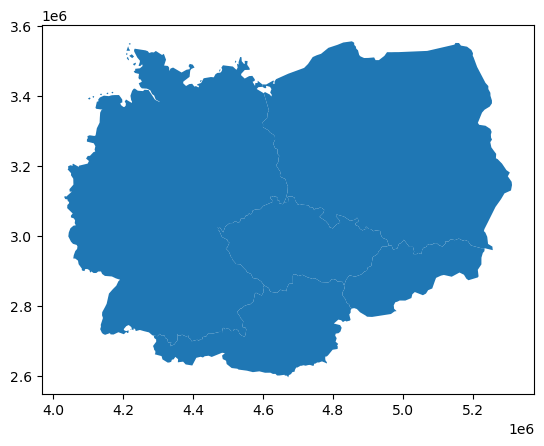

In [3]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

In [4]:
xmin, ymin, xmax, ymax = aoi.total_bounds

In [46]:
grid_size = 150000

<Axes: >

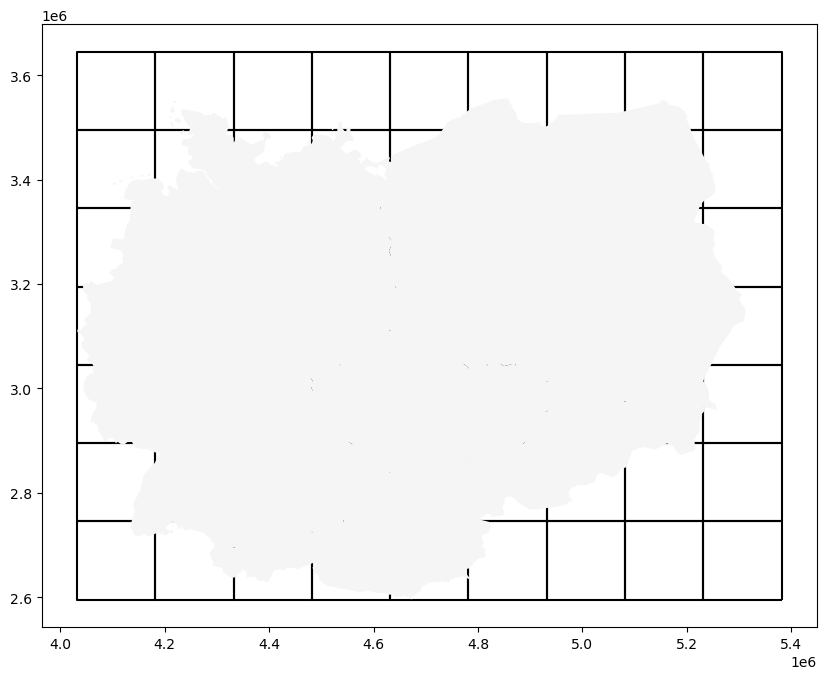

In [47]:
xcoords = np.arange(start=xmin, stop=xmax, step=grid_size)
ycoords = np.arange(start=ymin, stop=ymax, step=grid_size)
grid_coords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2)

grid_boxes = [box(x, y, x + grid_size, y + grid_size) for x, y in grid_coords]
grid_df = gpd.GeoDataFrame(geometry=grid_boxes, crs=aoi.crs)

ax = grid_df.boundary.plot(color="black", figsize=(10, 10))
aoi.plot(ax=ax, zorder=2, color="whitesmoke")

In [48]:
grid_df = grid_df.reset_index()

In [49]:
grid_df = grid_df.rename(columns={"index":"NAME"})

In [50]:
grid_df

,NAME,geometry
0,0,"POLYGON ((4181950.097 2595156.894, 4181950.097..."
1,1,"POLYGON ((4181950.097 2745156.894, 4181950.097..."
2,2,"POLYGON ((4181950.097 2895156.894, 4181950.097..."
3,3,"POLYGON ((4181950.097 3045156.894, 4181950.097..."
4,4,"POLYGON ((4181950.097 3195156.894, 4181950.097..."
...,...,...
58,58,"POLYGON ((5381950.097 2895156.894, 5381950.097..."
59,59,"POLYGON ((5381950.097 3045156.894, 5381950.097..."
60,60,"POLYGON ((5381950.097 3195156.894, 5381950.097..."
61,61,"POLYGON ((5381950.097 3345156.894, 5381950.097..."


In [51]:
joined = gpd.sjoin(buildings, grid_df, predicate="within")
indices = joined["index_right"].unique()
grid_df = grid_df.loc[indices]

<Axes: >

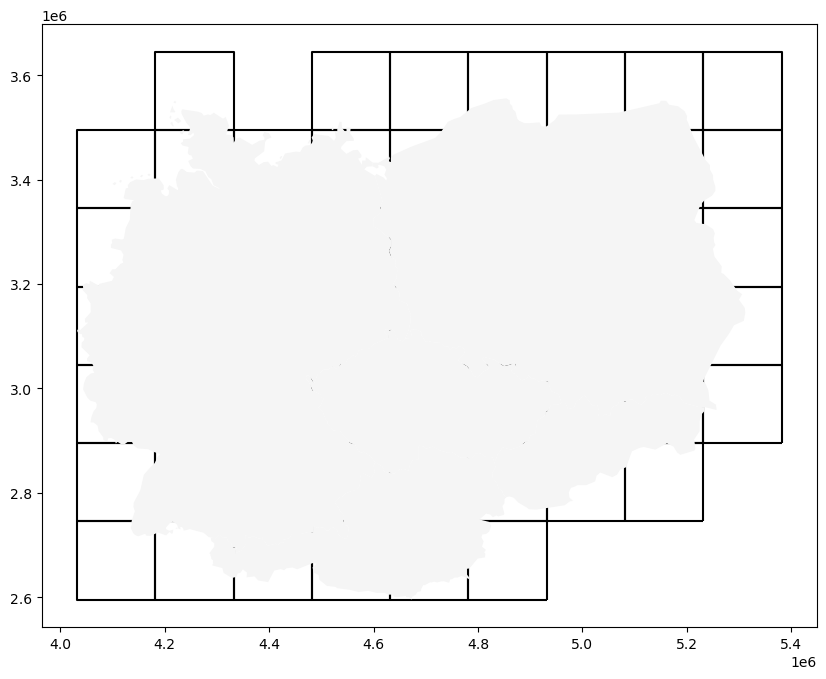

In [52]:
ax = grid_df.boundary.plot(color="black", figsize=(10, 10))
aoi.plot(ax=ax, zorder=2, color="whitesmoke")

In [53]:
building_counts = preprocess_data.get_building_counts_per_region(buildings, grid_df)

In [54]:
building_counts

NAME,0.0,1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,...,51.0,52.0,53.0,54.0,55.0,58.0,59.0,60.0,61.0,62.0
level_7,,,,,,,,,,,,,,,,,,,,,
1,213.0,780.0,6951.0,7205.0,6110.0,727.0,1250.0,9155.0,7607.0,4735.0,...,8159.0,10051.0,15172.0,7642.0,8098.0,670.0,1145.0,1646.0,80.0,7433.0
2,1316.0,5024.0,7475.0,88850.0,8177.0,285.0,1958.0,22598.0,47554.0,15296.0,...,6169.0,1754.0,2503.0,1720.0,2028.0,0.0,305.0,0.0,0.0,1133.0
3,477.0,1727.0,3100.0,13307.0,1805.0,783.0,3121.0,9802.0,12128.0,6104.0,...,6948.0,6889.0,6508.0,6150.0,4083.0,458.0,1895.0,441.0,278.0,1801.0
4,576.0,2153.0,9180.0,16552.0,13402.0,711.0,2885.0,13309.0,10987.0,9139.0,...,6726.0,6915.0,7804.0,5138.0,7499.0,370.0,1775.0,739.0,0.0,4150.0
5,815.0,5679.0,6716.0,123474.0,7353.0,1456.0,4913.0,25561.0,41947.0,15316.0,...,3263.0,2812.0,5949.0,1776.0,795.0,112.0,801.0,252.0,108.0,464.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5051.0,8345.0,16434.0,56435.0,13201.0,2519.0,6917.0,50847.0,52854.0,24753.0,...,2851.0,4234.0,5307.0,1741.0,747.0,960.0,824.0,922.0,13.0,11.0
107,1190.0,3257.0,18421.0,24950.0,18633.0,5332.0,9470.0,31666.0,19989.0,18809.0,...,2683.0,3021.0,3483.0,2728.0,1551.0,376.0,359.0,485.0,169.0,118.0
108,788.0,9612.0,55498.0,137260.0,3884.0,1158.0,1889.0,20855.0,152703.0,27195.0,...,1266.0,1339.0,1273.0,120.0,98.0,0.0,178.0,127.0,0.0,0.0


In [55]:
normalized_building_counts = preprocess_data.normalize_building_counts(building_counts)

In [56]:
normalized_building_counts

level_7,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
NAME,,,,,,,,,,,,,,,,,,,,,
0.0,0.001264,0.007808,0.002830,0.003417,0.004835,0.020433,0.000000,0.000000,0.000000,0.000148,...,0.003210,0.019905,0.001964,0.000386,0.001062,0.029967,0.007060,0.004675,0.014589,0.013580
1.0,0.001332,0.008579,0.002949,0.003677,0.009698,0.018830,0.000000,0.000000,0.000000,0.001165,...,0.005410,0.012370,0.011368,0.000827,0.000857,0.014250,0.005562,0.016414,0.039703,0.016930
2.0,0.002962,0.003185,0.001321,0.003912,0.002862,0.009544,0.000148,0.000000,0.000118,0.000931,...,0.008482,0.010547,0.007610,0.001741,0.001508,0.007002,0.007849,0.023647,0.054271,0.017244
3.0,0.000974,0.012010,0.001799,0.002237,0.016690,0.010600,0.000161,0.000000,0.000332,0.001676,...,0.022520,0.063492,0.031309,0.007889,0.000362,0.007629,0.003373,0.018554,0.032015,0.007726
4.0,0.003974,0.005318,0.001174,0.008716,0.004782,0.011791,0.000138,0.000000,0.000210,0.001134,...,0.009618,0.025955,0.007401,0.000860,0.001025,0.008586,0.012118,0.002526,0.003788,0.003753
5.0,0.001815,0.000711,0.001955,0.001775,0.003635,0.004421,0.000000,0.000000,0.000000,0.000417,...,0.004309,0.004785,0.002556,0.000334,0.001171,0.006288,0.013310,0.002891,0.001238,0.002956
7.0,0.002041,0.003197,0.005096,0.004711,0.008022,0.009493,0.000000,0.000000,0.000000,0.001092,...,0.005416,0.007813,0.005947,0.000091,0.004293,0.011294,0.015463,0.003084,0.000642,0.002077
8.0,0.002345,0.005789,0.002511,0.003409,0.006548,0.014279,0.000103,0.000000,0.000054,0.001102,...,0.007123,0.017180,0.014236,0.000856,0.001038,0.013025,0.008111,0.005342,0.008776,0.013731
9.0,0.001617,0.010109,0.002578,0.002336,0.008917,0.011054,0.000089,0.000000,0.000300,0.001403,...,0.008902,0.024450,0.018488,0.002058,0.000706,0.011236,0.004249,0.032463,0.036749,0.058612


In [57]:
bray_curtis_matrix = preprocess_data.compute_bc_matrix(normalized_building_counts)
bray_curtis_matrix

NAME,0.0,1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,...,51.0,52.0,53.0,54.0,55.0,58.0,59.0,60.0,61.0,62.0
NAME,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.256239,0.304418,0.449075,0.402343,0.416937,0.348216,0.261217,0.325118,0.241460,...,0.662955,0.801955,0.800413,0.811098,0.823981,0.773225,0.841983,0.835458,0.805836,0.789160
1.0,0.256239,0.000000,0.174936,0.377037,0.361855,0.414090,0.329760,0.172815,0.223362,0.140483,...,0.649283,0.796474,0.796853,0.800834,0.815117,0.788598,0.838889,0.832843,0.795638,0.782077
2.0,0.304418,0.174936,0.000000,0.393498,0.397217,0.429290,0.358170,0.225927,0.284572,0.153064,...,0.660452,0.809366,0.813442,0.811772,0.833818,0.807491,0.855391,0.853194,0.813562,0.799304
3.0,0.449075,0.377037,0.393498,0.000000,0.350803,0.492327,0.480092,0.391531,0.319287,0.403632,...,0.656306,0.798266,0.799546,0.804347,0.826864,0.836130,0.846238,0.835051,0.803450,0.801915
4.0,0.402343,0.361855,0.397217,0.350803,0.000000,0.261211,0.373270,0.307491,0.375225,0.349016,...,0.635052,0.680155,0.681835,0.706786,0.749233,0.712876,0.728019,0.722118,0.736126,0.727131
5.0,0.416937,0.414090,0.429290,0.492327,0.261211,0.000000,0.373286,0.391223,0.499634,0.373933,...,0.508362,0.642323,0.642665,0.668319,0.701145,0.677840,0.687599,0.665691,0.681839,0.669455
7.0,0.348216,0.329760,0.358170,0.480092,0.373270,0.373286,0.000000,0.337822,0.436589,0.325202,...,0.528249,0.668421,0.680081,0.703365,0.684976,0.597850,0.736679,0.708440,0.712542,0.630212
8.0,0.261217,0.172815,0.225927,0.391531,0.307491,0.391223,0.337822,0.000000,0.234150,0.154087,...,0.671771,0.810527,0.802125,0.811835,0.818417,0.796699,0.845744,0.840102,0.804701,0.787384
9.0,0.325118,0.223362,0.284572,0.319287,0.375225,0.499634,0.436589,0.234150,0.000000,0.264194,...,0.713635,0.846144,0.833160,0.836304,0.854202,0.850150,0.881345,0.871522,0.833050,0.832600


/tmp/ipykernel_3919472/2280991263.py:35: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
/tmp/ipykernel_3919472/2280991263.py:35: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
/tmp/ipykernel_3919472/2280991263.py:35: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
/tmp/ipykernel_3919472/2280991263.py:35: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=

<Axes: >

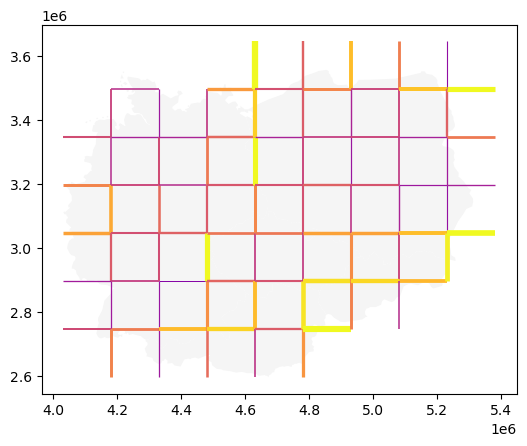

In [60]:
#Segment boundaries between adjacent regions
indices = grid_df.sindex.query(grid_df.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = grid_df.iloc[left].intersection(grid_df.iloc[right], align=False)
left = grid_df.NAME.iloc[left]
right = grid_df.NAME.iloc[right]

#Retrieve BC dissimilarity values between every two adjacent regions
border_widths = []
for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])

#Recalculate border widths so that higher BC dissimilarity values are emphasized
line_widths = [(0.1 + 2*(np.exp(2*w) - 1)) for w in border_widths]

cmap = "plasma"
#Create a colormap to emphasize higher BC dissimilarity values between adjacent regions
norm=plt.Normalize(0, .5)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
if isinstance(cmap, str):
    cmap = matplotlib.colormaps[cmap]

#Plotting
#if ax:
#    for geom, width, border in zip (geoms, line_widths, border_widths):
#        gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
#        ax.set_title(f"{boundary_name.replace("_", " (")})", fontdict=dict(fontsize=6))
#else:
fig, ax = plt.subplots()
for geom, width, border in zip (geoms, line_widths, border_widths):
    gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
aoi.plot(ax=ax, zorder=1, color="whitesmoke")

In [18]:
right

1        1
10      10
11      11
2        2
10      10
      ... 
125    125
126    126
127    127
128    128
129    129
Name: NAME, Length: 453, dtype: int64

In [19]:
left

0        0
0        0
0        0
1        1
1        1
      ... 
124    124
125    125
126    126
127    127
128    128
Name: NAME, Length: 453, dtype: int64